# Walkthrough on ChristmAIs API
Let's spread some algorithmic cheer throughout the holidays! This time, Thinking Machines Data Science presents you a package, `christmais`, to
generate abstract art using the idea of perception engines from [Tom White](https://medium.com/artists-and-machine-intelligence/perception-engines-8a46bc598d57). This notebook serves as a short walkthrough on how to use this API. 

In [1]:
# Ensures that we're using the local version of christmAIs
import sys
sys.path.append('../')

# Some IPython magic to autoreload modules
%load_ext autoreload
%autoreload 2

In [2]:
# Import modules
from christmais import (get_fasttext_pretrained, Artist)
from christmais import Predictor
from christmais import Trainer
import numpy as np

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


## FastText: Get a word embedding from text

The first step in this process is to get a word embedding from a given string input. For this we use gensim's FastText algorithm to do just that. The loaded `FastText` model was pretrained from the `brown` corpus. It turns out that for our purposes, training on this corpus is enough.

First, it checks if you have a trained `brown_fasttext.model` model in your `/tmp` directory. If there's none, then it will automatically train and save one for you!

In [3]:
model = get_fasttext_pretrained(load=True)

INFO:gensim.utils:loading FastTextWrapper object from C:\Users\ISSATI~1\AppData\Local\Temp\brown_fasttext.model
INFO:gensim.utils:loading wv recursively from C:\Users\ISSATI~1\AppData\Local\Temp\brown_fasttext.model.wv.* with mmap=None
INFO:gensim.utils:setting ignored attribute vectors_norm to None
INFO:gensim.utils:setting ignored attribute vectors_vocab_norm to None
INFO:gensim.utils:setting ignored attribute vectors_ngrams_norm to None
INFO:gensim.utils:setting ignored attribute buckets_word to None
INFO:gensim.utils:loading vocabulary recursively from C:\Users\ISSATI~1\AppData\Local\Temp\brown_fasttext.model.vocabulary.* with mmap=None
INFO:gensim.utils:loading trainables recursively from C:\Users\ISSATI~1\AppData\Local\Temp\brown_fasttext.model.trainables.* with mmap=None
INFO:gensim.utils:loaded C:\Users\ISSATI~1\AppData\Local\Temp\brown_fasttext.model


In case you found the `brown` dataset insufficient and you wish to train on your own data, then worry not! We provided a `FastTextWrapper` so that you can work on your own data. Simply create an instance of the `FastTextWrapper` by providing your own sentences and additional keyword arguments as with gensim's [FastText](https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText):

```python
from christmais.models import FastTextWrapper
#  Assuming you already have your own corpus loaded
model = FastTextWrapper(sentences=my_own_corpus, **kwargs)
```

Once we have our trained model, we can then create a word embedding out of any input string:

In [4]:
embedding = model.transform("Thinking Machines Data Science")
print(embedding)

[0.52606106 0.5434932  0.01999998 0.78087074 0.97999996 0.6864882
 0.04613805 0.9232513 ]


The embedding is represented as a vector of size 8, since this is the same configuration used in the original perception engine. For the next step, we will then use this embedding as a "seed" for our drawing system.

## Artist: Draw an image using the word embedding

In this step, we call our drawing system, aptly named `Artist`, to create an abstract image using the embedding as a seed. Here, we took inspiration from Tom White's [dopes repository](https://github.com/dribnet/dopes).

In [5]:
artist = Artist(embedding, dims=(224, 224))

Once we have an artist, we can now generate some abstract art!

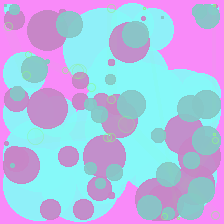

In [6]:
artist.draw()

Note that each instatiation of the `Artist` class determines the color scheme of the resulting image. The positions of the lines and circles change whenever the `draw()` method is called. So if you want different palettes, instantiate multiple `Artist`s. Each of them can `draw()` different images whenever called.

### A note on genes

For our optimization routine, we exposed the positions of the circles and lines in an attribute called "gene." Each image has its own gene, and you can always create the same image given same genes. To get the gene value of the **last drawn image**, just call `get_gene()`

In [7]:
gene = artist.get_gene()
print(gene)

[[178 152  28 113 101 178  99 188  16  99  16 159 191 160  99 114 114 172
   25  12   8 107 137 111 137   4]
 [102 102 102  79 175 175  80  80 101 101  80 101 100 183  14   9 110  79
   17   8   5 214 134 214   5   1]
 [180 109 103  48  80 181  47  30  47  30  47 108 190 108  69  24 190 206
   40  20  13 126 124  35 136   8]
 [193 163 193 111 127 127  62  12 111 195 111  62  12 165  47  61  61  19
    6   3   2  91  87 215 215   4]
 [152  29 132  24  24  73  14  19  14 156  68 156 199  11  17  93 158 135
   21  10   7 111   8 111  99   4]
 [  9   9 213   9   9   9 215   6   6 143 143  18   5   5 162  17   5   5
    5   2   1 164 216 215 140   3]
 [200 105 200  93  56 116  83 209  50 209 116 104  90 104  90 168 168 213
   20  10   6 178 218 144   8   1]
 [145 106 103 145 131 103 156 199 104 156 199 156 206 104 131 104 206 140
   43  21  14  28  54  65  70   3]
 [155 155  39 155  39 184  21 165 119 119 165 202 168 174 207  16 149 207
   36  18  12  26  75   8  26   4]
 [129  80 176 176 1

As you can see, the `gene` is simply a matrix of shape `(density, 26)`. Again, we can re-draw the same image once we know its gene. We do that by calling `draw_from_gene()`

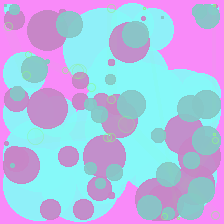

In [8]:
artist.draw_from_gene(gene)

## Predictor: Predict the abstract art's nearest ImageNet class

Once we have an image, what we can do next is pass it to a classifier, in this case Resnet-152, to estimate how near it is to our target ImageNet class. The `Predictor` class gives us a handy way to abstract that. By supplying a target ImageNet class, we can call the `predict()` method and it will give us the confidence/score on how well it predicted our target class.

In [15]:
p = Predictor()

INFO:root:Loading labels file C:\Users\ISSATI~1\AppData\Local\Temp\labels.json


In [10]:
img = artist.draw_from_gene(gene) # We'll use the same image we got earlier
scores, results = p.predict(X=img, 
                            target="iron") # We'll see how well it predicts the class "iron"

..\christmais\predictor.py:233: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = sm(fc_out)


In [11]:
print('The score of predicting `iron` is {}, not that really high'.format(scores))

The score of predicting `iron` is 0.00023460743250325322, not that really high


In addition, we can also check the nearest classes it predicted. Here, we can call the method `plot_results` while supplying the `results` dictionary from `predict`

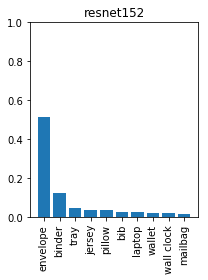

In [12]:
p.plot_results(results)

## Trainer: Optimize your images to look like the target class

As we've seen the score for our target class is rather low. What we will do next is optimize the images generated by our `Artist`s using an optimization algorithm. For `christmais`, we're using a genetic algorithm. Now, we will be introducing the `Trainer` class that integrates the three components (`FastText`, `Artist`, `Predictor`) together in a nice API.

In [3]:
string = 'Thinking Machines Data Science' # string to get an embedding from
t = Trainer(string)

INFO:gensim.utils:loading FastTextWrapper object from C:\Users\ISSATI~1\AppData\Local\Temp\brown_fasttext.model
INFO:gensim.utils:loading wv recursively from C:\Users\ISSATI~1\AppData\Local\Temp\brown_fasttext.model.wv.* with mmap=None
INFO:gensim.utils:setting ignored attribute vectors_norm to None
INFO:gensim.utils:setting ignored attribute vectors_vocab_norm to None
INFO:gensim.utils:setting ignored attribute vectors_ngrams_norm to None
INFO:gensim.utils:setting ignored attribute buckets_word to None
INFO:gensim.utils:loading vocabulary recursively from C:\Users\ISSATI~1\AppData\Local\Temp\brown_fasttext.model.vocabulary.* with mmap=None
INFO:gensim.utils:loading trainables recursively from C:\Users\ISSATI~1\AppData\Local\Temp\brown_fasttext.model.trainables.* with mmap=None
INFO:gensim.utils:loaded C:\Users\ISSATI~1\AppData\Local\Temp\brown_fasttext.model
INFO:christmais.trainer:Built FastText model
INFO:christmais.trainer:Embedding created for `Thinking Machines Data Science`
INFO

Given this, we can now call the `train()` method. It returns the best individual that we can call to draw

In [ ]:
best_gene = t.train(target='cellular telephone', steps=10)

There are a lot of options available inside `train`. I'd recommend that you call `help(t.train)` to see all available parameters. One thing that you might use is the `outdir` parameter. If supplied with a directory name, it draws the resulting image *per generation* in that directory. 

Now, let's examine `best_gene`:

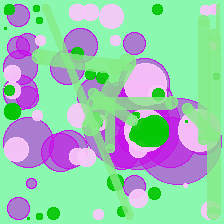

In [15]:
best_gene.artist.draw()

### Setting the colorscheme beforehand

We can play with the optimization parameters and set the colorschme beforehand. Here we can call `t.set_colors` and pass it a dictionary of colors with keys: `background`, `layer1`, `layer2`, `layer3`, and `lines`.

In [4]:
string = 'Thinking Machines Data Science' # string to get an embedding from
t1 = Trainer(string) # let's make a new trainer

# Set colorscheme
new_colorscheme = {
    'background' : (255, 255, 255, 255),
    'layer1' : (232,232,232, 255),
    'layer2' : (232,232,232, 255),
    'layer3' : (232,232,232, 255),
    'lines'  : (255, 0, 0, 255)
}
t1.set_colors(new_colorscheme)

INFO:gensim.utils:loading FastTextWrapper object from C:\Users\ISSATI~1\AppData\Local\Temp\brown_fasttext.model
INFO:gensim.utils:loading wv recursively from C:\Users\ISSATI~1\AppData\Local\Temp\brown_fasttext.model.wv.* with mmap=None
INFO:gensim.utils:setting ignored attribute vectors_norm to None
INFO:gensim.utils:setting ignored attribute vectors_vocab_norm to None
INFO:gensim.utils:setting ignored attribute vectors_ngrams_norm to None
INFO:gensim.utils:setting ignored attribute buckets_word to None
INFO:gensim.utils:loading vocabulary recursively from C:\Users\ISSATI~1\AppData\Local\Temp\brown_fasttext.model.vocabulary.* with mmap=None
INFO:gensim.utils:loading trainables recursively from C:\Users\ISSATI~1\AppData\Local\Temp\brown_fasttext.model.trainables.* with mmap=None
INFO:gensim.utils:loaded C:\Users\ISSATI~1\AppData\Local\Temp\brown_fasttext.model
INFO:christmais.trainer:Built FastText model
INFO:christmais.trainer:Embedding created for `Thinking Machines Data Science`
INFO

In [ ]:
best_gene1 = t1.train(target='shopping basket', steps=50, outdir='shopping_basket/')

..\christmais\predictor.py:233: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = sm(fc_out)


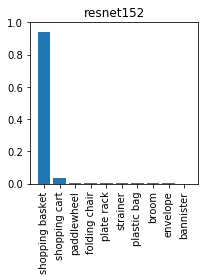

In [18]:
img = best_gene1.artist.draw_from_gene(best_gene1.gene) 
scores, results = p.predict(X=img, target="shopping basket") 
p.plot_results(results)

## Cellphone

In [4]:
string = 'Thinking Machines Data Science' # string to get an embedding from
t1 = Trainer(string) # let's make a new trainer

# Set colorscheme
new_colorscheme = {
    'background' : (255, 255, 255, 255),
    'layer1' : (192,192,192, 255),
    'layer2' : (192,192,192, 255),
    'layer3' : (192,192,192, 255),
    'lines'  : (0, 0, 0, 255)
}
t1.set_colors(new_colorscheme)

INFO:gensim.utils:loading FastTextWrapper object from C:\Users\ISSATI~1\AppData\Local\Temp\brown_fasttext.model
INFO:gensim.utils:loading wv recursively from C:\Users\ISSATI~1\AppData\Local\Temp\brown_fasttext.model.wv.* with mmap=None
INFO:gensim.utils:setting ignored attribute vectors_norm to None
INFO:gensim.utils:setting ignored attribute vectors_vocab_norm to None
INFO:gensim.utils:setting ignored attribute vectors_ngrams_norm to None
INFO:gensim.utils:setting ignored attribute buckets_word to None
INFO:gensim.utils:loading vocabulary recursively from C:\Users\ISSATI~1\AppData\Local\Temp\brown_fasttext.model.vocabulary.* with mmap=None
INFO:gensim.utils:loading trainables recursively from C:\Users\ISSATI~1\AppData\Local\Temp\brown_fasttext.model.trainables.* with mmap=None
INFO:gensim.utils:loaded C:\Users\ISSATI~1\AppData\Local\Temp\brown_fasttext.model
INFO:christmais.trainer:Built FastText model
INFO:christmais.trainer:Embedding created for `Thinking Machines Data Science`
INFO

In [ ]:
best_gene1 = t1.train(target='cellular telephone', steps=100, outdir='cellular_telephone/')